In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

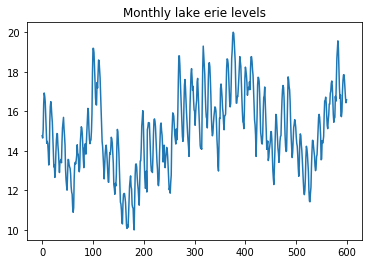

In [2]:
training_set = pd.read_csv('./monthly-lake-erie-levels-1921-19.csv')
training_set = training_set.iloc[:,1:2].values


plt.plot(training_set)
plt.title('Monthly lake erie levels') #伊利湖水平線
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler #透過MinMaxScaler轉換到0~1
sc = MinMaxScaler() 
training_data = sc.fit_transform(training_set)

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1): #為了能夠依據seq_length做截斷的做動作
        _x = data[i:(i+seq_length)] #訓練集，依據seq_length取一批
        _y = data[i+seq_length] #測試集，依據seq_length取一筆
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [5]:
seq_length = 12 #長度，因為12月份，一般可以用資料節點的長度來估計
learning_rate = 0.01 #學習率
input_size = 1 #輸入層
hidden_size = 5 #隱藏層
num_classes = 1 #分類數量
num_layers = 1 #LSTM層數，如果設定2則是兩個放在一起
num_epochs = 400 #迭代

In [6]:
x, y = sliding_windows(training_data, seq_length) #每seq_length一段

train_size = int(len(y) *0.7) #設定訓練集大小，train_size大小會影響到圖的密集程度，數值乘越大越鬆
test_size = len(y) - train_size #設定測試集大小
trainX = torch.Tensor(np.array(x[0:train_size])) #一批資料 取訓練集0~410的資料
trainX = Variable(trainX) #把變數存起來
testX = torch.Tensor(np.array(x[train_size:len(x)]))#一批資料 取訓練集410~587的資料
testX = Variable(testX) #把變數存起來


trainY = torch.Tensor(np.array(y[0:train_size])) #取預測集0~410的資料
trainY = Variable(trainY) #把變數存起來
testY = torch.Tensor(np.array(y[train_size:len(y)])) #取預測集410~587的資料
testY = Variable(testY) #把變數存起來 取測試值測試用

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #num_classes = 1 分類數量 只有一個預測值
        self.num_layers = num_layers #num_layers = 1 #LSTM層數，設定太多層會導致預測不夠平滑
        self.input_size = input_size #input_size = 1 #輸入層
        self.hidden_size = hidden_size #hidden_size = 5 #隱藏層
        self.seq_length = seq_length #seq_length = 12 #長度，因為12月份
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #上面動作也等於lstm(1,1,1,True)，但這裡主要是設計網路用
        self.fc = nn.Linear(hidden_size, num_classes) #建立線性轉換

    def forward(self, x): #前向傳播
        #隱藏元
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        #記憶元
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0)) #使用_表示不重要的變數
        #第一维sequence，第二维度mini-batch，第三位輸入elements of input
        h_out = h_out.view(-1, self.hidden_size) #-1就是由Torch自己決定out內容
        out = self.fc(h_out)
        return out

In [8]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) #使用Adam優化器

# 訓練模型
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # 回傳Loss
    loss = criterion(outputs, trainY)
    loss.backward() #反向傳播
    optimizer.step() #進行優化
    #if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



Epoch: 0, loss: 0.14196
Epoch: 1, loss: 0.12362
Epoch: 2, loss: 0.10652
Epoch: 3, loss: 0.09085
Epoch: 4, loss: 0.07685
Epoch: 5, loss: 0.06481
Epoch: 6, loss: 0.05503
Epoch: 7, loss: 0.04786
Epoch: 8, loss: 0.04364
Epoch: 9, loss: 0.04246
Epoch: 10, loss: 0.04398
Epoch: 11, loss: 0.04712
Epoch: 12, loss: 0.05026
Epoch: 13, loss: 0.05217
Epoch: 14, loss: 0.05239
Epoch: 15, loss: 0.05115
Epoch: 16, loss: 0.04897
Epoch: 17, loss: 0.04645
Epoch: 18, loss: 0.04406
Epoch: 19, loss: 0.04211
Epoch: 20, loss: 0.04075
Epoch: 21, loss: 0.03995
Epoch: 22, loss: 0.03962
Epoch: 23, loss: 0.03961
Epoch: 24, loss: 0.03977
Epoch: 25, loss: 0.03996
Epoch: 26, loss: 0.04007
Epoch: 27, loss: 0.04004
Epoch: 28, loss: 0.03982
Epoch: 29, loss: 0.03940
Epoch: 30, loss: 0.03880
Epoch: 31, loss: 0.03806
Epoch: 32, loss: 0.03722
Epoch: 33, loss: 0.03634
Epoch: 34, loss: 0.03546
Epoch: 35, loss: 0.03463
Epoch: 36, loss: 0.03387
Epoch: 37, loss: 0.03318
Epoch: 38, loss: 0.03256
Epoch: 39, loss: 0.03197
Epoch: 40,

Epoch: 352, loss: 0.00254
Epoch: 353, loss: 0.00254
Epoch: 354, loss: 0.00254
Epoch: 355, loss: 0.00253
Epoch: 356, loss: 0.00253
Epoch: 357, loss: 0.00253
Epoch: 358, loss: 0.00253
Epoch: 359, loss: 0.00253
Epoch: 360, loss: 0.00253
Epoch: 361, loss: 0.00253
Epoch: 362, loss: 0.00253
Epoch: 363, loss: 0.00253
Epoch: 364, loss: 0.00253
Epoch: 365, loss: 0.00253
Epoch: 366, loss: 0.00252
Epoch: 367, loss: 0.00252
Epoch: 368, loss: 0.00252
Epoch: 369, loss: 0.00252
Epoch: 370, loss: 0.00252
Epoch: 371, loss: 0.00252
Epoch: 372, loss: 0.00252
Epoch: 373, loss: 0.00252
Epoch: 374, loss: 0.00252
Epoch: 375, loss: 0.00252
Epoch: 376, loss: 0.00252
Epoch: 377, loss: 0.00252
Epoch: 378, loss: 0.00252
Epoch: 379, loss: 0.00251
Epoch: 380, loss: 0.00251
Epoch: 381, loss: 0.00251
Epoch: 382, loss: 0.00251
Epoch: 383, loss: 0.00251
Epoch: 384, loss: 0.00251
Epoch: 385, loss: 0.00251
Epoch: 386, loss: 0.00251
Epoch: 387, loss: 0.00251
Epoch: 388, loss: 0.00251
Epoch: 389, loss: 0.00251
Epoch: 390, 

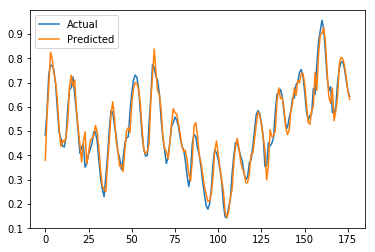

In [9]:
lstm.eval() #確認模型的狀況
test_predict = lstm(testX) #測試資料餵入模型

test_predict = test_predict.data.numpy() 
testY = testY.data.numpy()
plt.plot(testY, label="Actual")
plt.plot(test_predict, label="Predicted") 
plt.legend()
plt.show()